C:\Users\Bill\AppData\Local\Temp\ipykernel_20212\3037933797.py:137: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


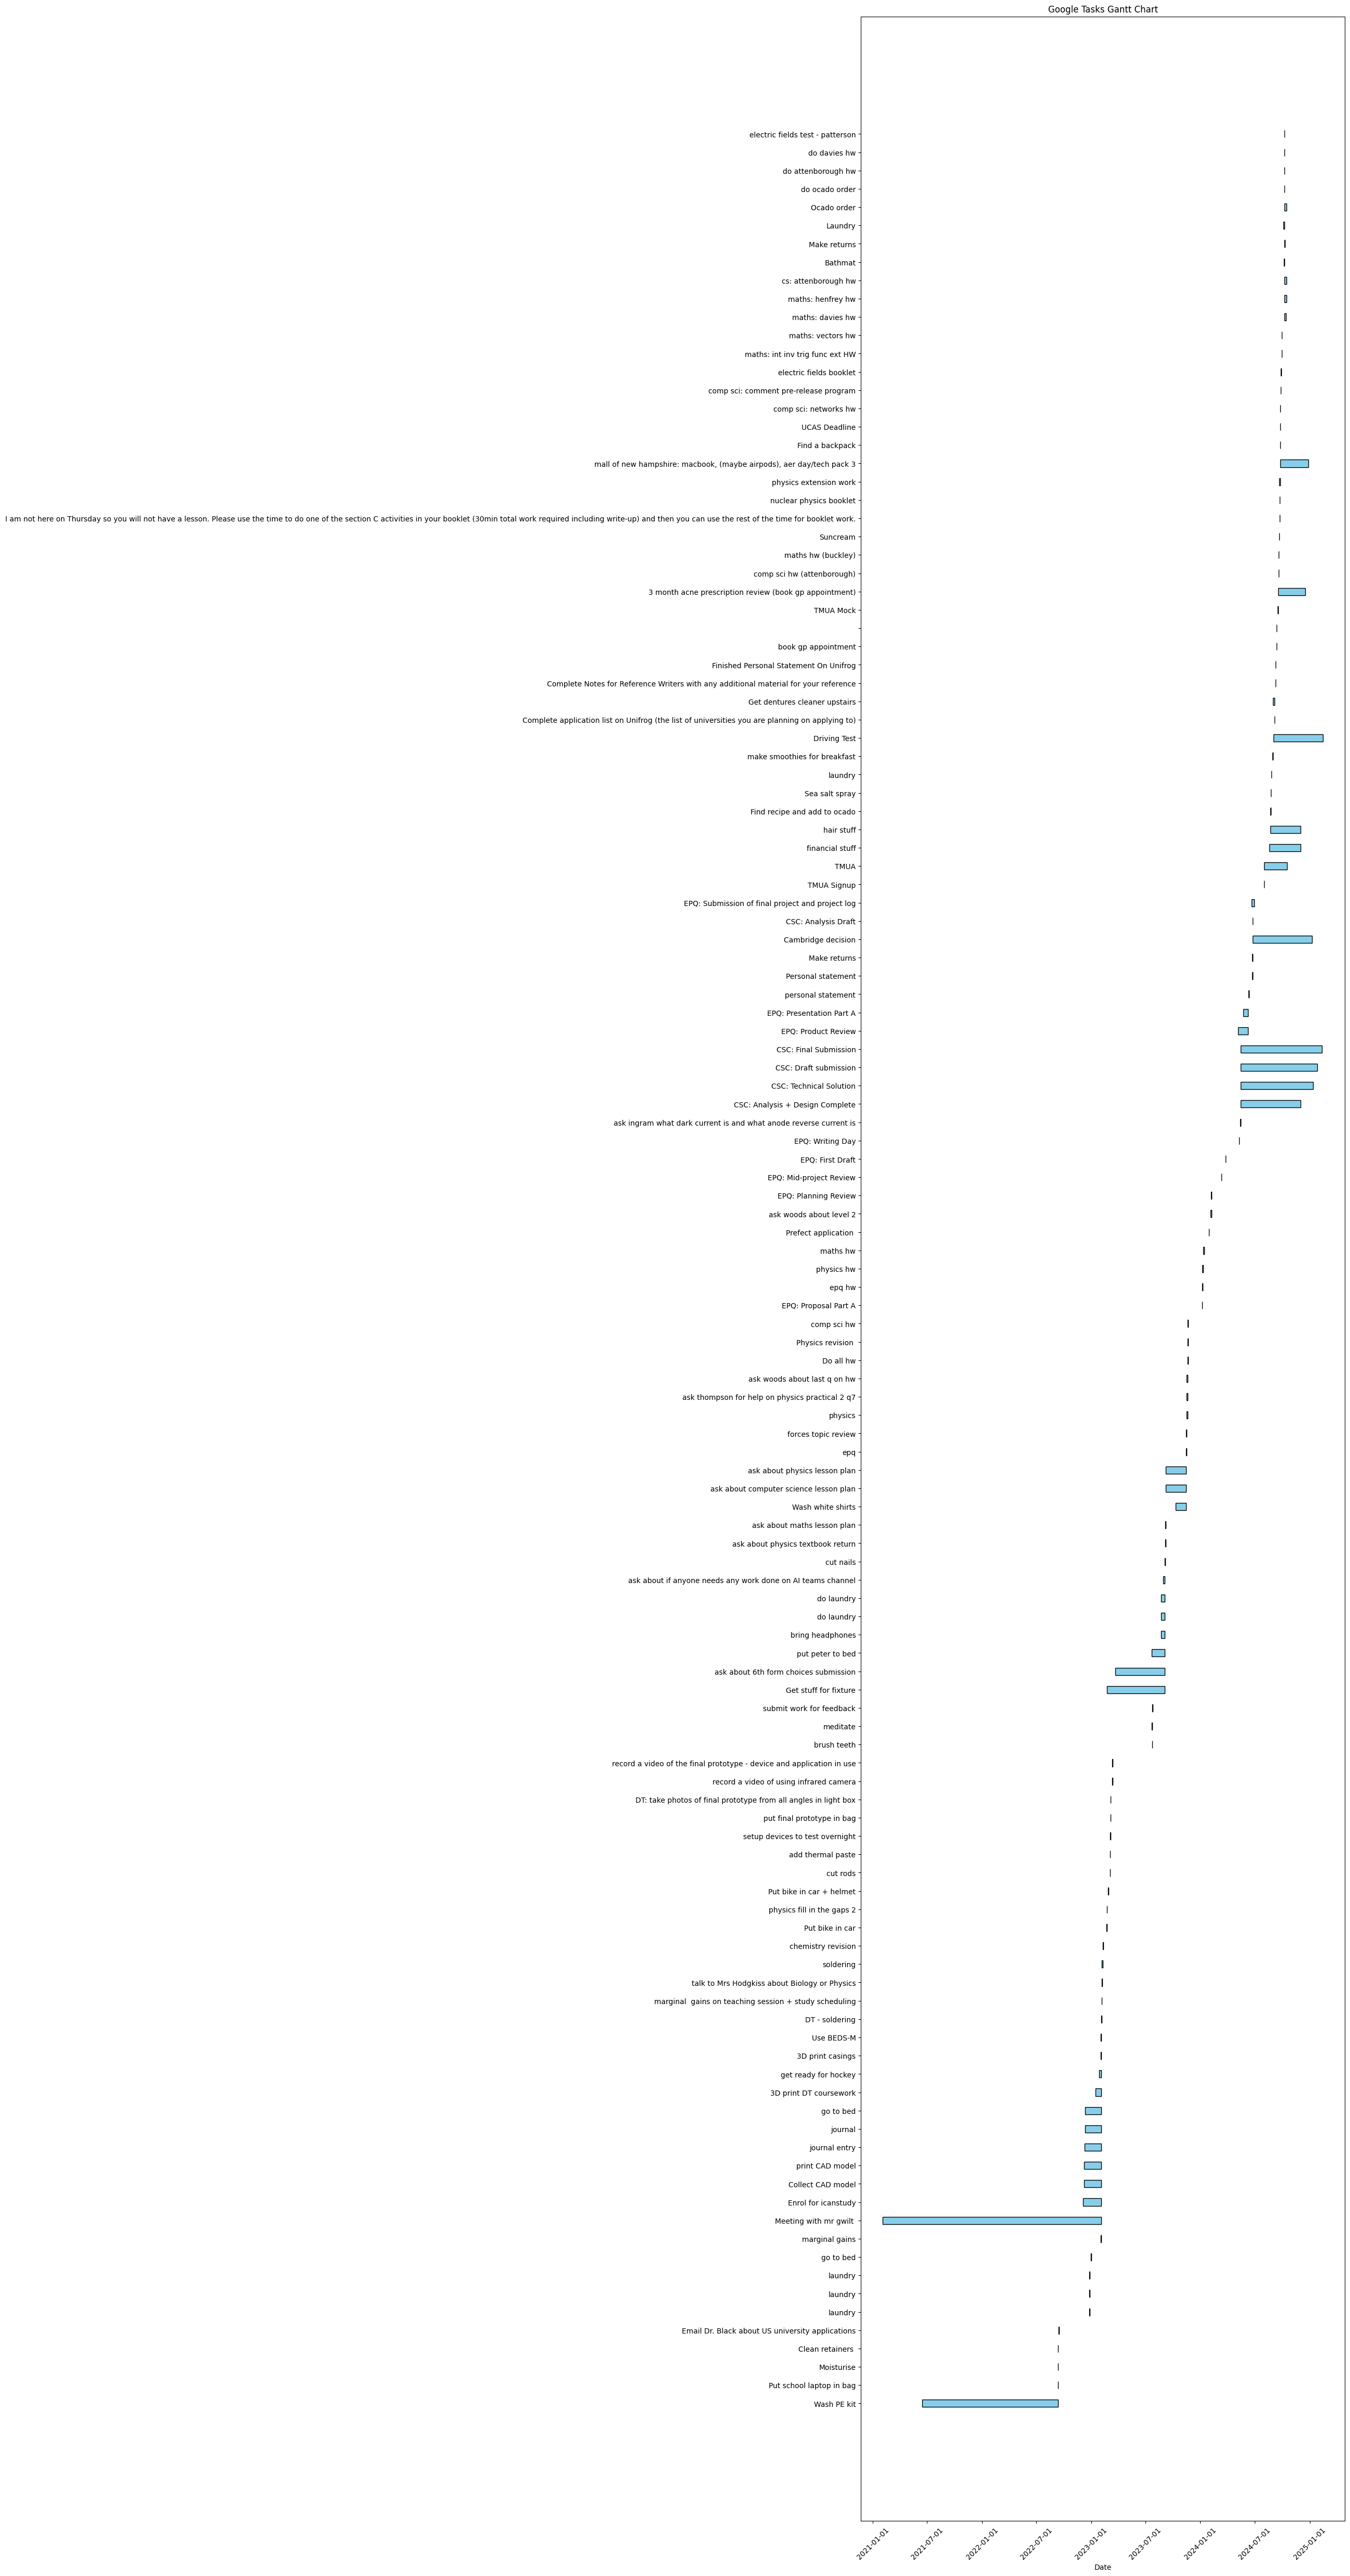

In [5]:
from __future__ import print_function
from datetime import datetime, timedelta
import os.path
import pickle
from dateutil.parser import parse
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from google.auth.transport.requests import Request
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build

# If modifying these scopes, delete the file token.pickle.
SCOPES = ['https://www.googleapis.com/auth/tasks.readonly']

def main():
    """Retrieves tasks from Google Tasks and visualizes them as a Gantt chart."""
    creds = None
    # The file token.pickle stores the user's access and refresh tokens.
    if os.path.exists('token.pickle'):
        with open('token.pickle', 'rb') as token:
            creds = pickle.load(token)
    # If no valid credentials are available, prompt the user to log in.
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            # Ensure you have the 'credentials.json' file in your directory.
            flow = InstalledAppFlow.from_client_secrets_file(
                'credentials.json', SCOPES)
            creds = flow.run_local_server(port=0)
        # Save the credentials for future runs.
        with open('token.pickle', 'wb') as token:
            pickle.dump(creds, token)

    service = build('tasks', 'v1', credentials=creds)

    # Retrieve all task lists.
    results = service.tasklists().list(maxResults=100).execute()
    tasklists = results.get('items', [])

    if not tasklists:
        print('No task lists found.')
        return

    all_tasks = []

    # Iterate over each task list and retrieve tasks.
    for tasklist in tasklists:
        tasks = []
        page_token = None

        # Retrieve tasks in pages until all tasks are fetched.
        while True:
            tasks_result = service.tasks().list(
                tasklist=tasklist['id'],
                maxResults=100,
                pageToken=page_token,
                showCompleted=True,
                showDeleted=False,
                showHidden=True
            ).execute()
            
            tasks.extend(tasks_result.get('items', []))
            page_token = tasks_result.get('nextPageToken')

            if not page_token:
                break

        for task in tasks:
            title = task.get('title', 'No Title')
            due = task.get('due', None)
            created = task.get('updated', None)  # Using 'updated' as 'created' might not always be set
            status = task.get('status', 'needsAction')
            if due:
                due_datetime = parse(due)
            else:
                due_datetime = None
            if created:
                created_datetime = parse(created)
            else:
                # If 'created' is not available, set 'start' to 'due' minus default duration.
                if due_datetime:
                    created_datetime = due_datetime - timedelta(days=1)
                else:
                    created_datetime = None
            all_tasks.append({
                'title': title,
                'start': created_datetime,
                'end': due_datetime,
                'status': status
            })

    # Visualize the tasks as a Gantt chart.
    visualize_tasks(all_tasks)

def visualize_tasks(tasks):
    """Visualizes tasks with start and due dates using matplotlib as a Gantt chart."""
    # Filter tasks that have start and end dates.
    tasks_with_dates = [task for task in tasks if task['start'] is not None and task['end'] is not None]
    if not tasks_with_dates:
        print('No tasks with start and end dates to visualize.')
        return

    # Sort tasks by start date.
    tasks_with_dates.sort(key=lambda x: x['start'])

    # Prepare data for Gantt chart.
    task_names = [task['title'] for task in tasks_with_dates]
    start_dates = [task['start'] for task in tasks_with_dates]
    end_dates = [task['end'] for task in tasks_with_dates]
    durations = [end - start for start, end in zip(start_dates, end_dates)]
    durations_in_days = [duration.total_seconds() / 86400 for duration in durations]

    # Prepare the y positions.
    y_pos = range(len(task_names))

    # Convert dates to matplotlib format.
    start_dates_num = mdates.date2num(start_dates)

    # Create the figure and the bar plot.
    fig, ax = plt.subplots(figsize=(12, max(6, len(task_names) * 0.5)))
    ax.barh(y_pos, durations_in_days, left=start_dates_num, align='center', height=0.4, color='skyblue', edgecolor='black')

    # Set the y-axis labels.
    ax.set_yticks(y_pos)
    ax.set_yticklabels(task_names)

    # Format the x-axis with date labels.
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45)

    # Set labels and title.
    plt.xlabel('Date')
    plt.title('Google Tasks Gantt Chart')
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()
